# Find Classwise Accuracy

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
#tf.enable_eager_execution()

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_random_seed(13)

import py3nvml
py3nvml.grab_gpus(1)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passi

1

In [3]:
multi_step = False
model_path = "trained_models/LSTM3.h5"

# Load the dataset

In [4]:
dataset = np.load('../compressed_2/full_data.npy')
print("Before: ", dataset.shape)
#Swap axes
dataset = dataset.swapaxes(1, -1)

#Combine station and xyz
#dataset = dataset.reshape(dataset.shape[0], dataset.shape[1], -1)
print("After: ", dataset.shape)

Before:  (35679, 15, 60)
After:  (35679, 60, 15)


In [5]:
richters_path = "../richters_2.npy"
richters = np.load(richters_path)
print(len(richters))
print(min(richters), max(richters))

classes = [0, 1, 2, 3]
richters_discrete = np.zeros_like(richters)
richters_discrete += np.where(richters >= 5., np.ones_like(richters), np.zeros_like(richters))
richters_discrete += np.where(richters >= 3., np.ones_like(richters), np.zeros_like(richters))
richters_discrete += np.where(richters >= 1., np.ones_like(richters), np.zeros_like(richters))

35679
-0.49 7.1


Text(0, 0.5, 'Num Earthquakes')

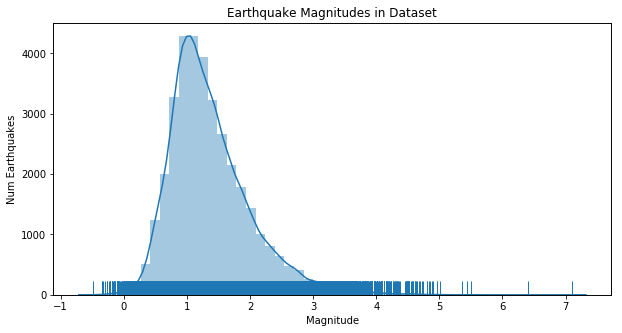

In [6]:
# Characterize the magnitudes
import seaborn as sns
f,ax1 = plt.subplots(figsize=(10, 5))
sns.distplot(richters,kde=False,ax=ax1, rug=True)
ax2 = ax1.twinx()
ax2.yaxis.set_ticks([])
sns.kdeplot(richters,ax=ax2)
plt.title("Earthquake Magnitudes in Dataset")
ax1.set_xlabel('Magnitude')
ax1.set_ylabel('Num Earthquakes')

In [7]:
def shuffle_together(x, y):
    ## Shuffle together two arrays of the exact same dimensions
    idxs = np.arange(x.shape[0])
    np.random.seed(13)
    np.random.shuffle(idxs)
    x = x[idxs]
    y = y[idxs]
    return x, y

dataset, richters_discrete = shuffle_together(dataset, richters_discrete)


In [8]:
data_mean = np.mean(dataset, axis = 1)
data_var = np.linalg.norm(dataset - np.expand_dims(data_mean, 1), axis = 1)

#Add some epsilon to make the divide by zero var work
epsilon = 1
data_var[data_var == 0] = epsilon
data_var[data_var == 0] = epsilon

dataset = (dataset - np.expand_dims(data_mean, 1))/np.expand_dims(data_var, 1)

In [9]:
def multivariate_data(dataset, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = history_size
    end_index = dataset.shape[1] - target_size
        
    for quake in dataset:

        for i in range(start_index, end_index):
            indices = range(i-history_size, i, step)
            data.append(quake[indices])

            if single_step:
                labels.append(quake[i+target_size])
            else:
                labels.append(quake[i:i+target_size])

    return np.array(data), np.array(labels)

# Segment earthquakes by magnitude

(array([1.0728e+04, 0.0000e+00, 0.0000e+00, 2.3971e+04, 0.0000e+00,
        0.0000e+00, 9.7400e+02, 0.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

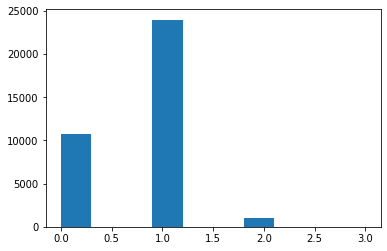

In [10]:
plt.hist(richters_discrete)

In [11]:
TRAIN_SPLIT_IDX = int(dataset.shape[0]*0.8)
val_dataset = dataset[TRAIN_SPLIT_IDX:]
val_richters_discrete = richters_discrete[TRAIN_SPLIT_IDX:]
val_data_mean = data_mean[TRAIN_SPLIT_IDX:]
val_data_var = data_var[TRAIN_SPLIT_IDX:]


quakes0 = val_dataset[val_richters_discrete == 0]
val_data_mean0 = val_data_mean[val_richters_discrete == 0]
val_data_var0 = val_data_var[val_richters_discrete == 0]

quakes1 = val_dataset[val_richters_discrete == 1]
val_data_mean1 = val_data_mean[val_richters_discrete == 1]
val_data_var1 = val_data_var[val_richters_discrete == 1]

quakes2 = val_dataset[val_richters_discrete == 2]
val_data_mean2 = val_data_mean[val_richters_discrete == 2]
val_data_var2 = val_data_var[val_richters_discrete == 2]

quakes3 = val_dataset[val_richters_discrete == 3]
val_data_mean3 = val_data_mean[val_richters_discrete == 3]
val_data_var3 = val_data_var[val_richters_discrete == 3]

len(quakes0), len(quakes1), len(quakes2), len(quakes3)

(2229, 4705, 202, 0)

In [12]:
past_history = 15
future_target = 5 if multi_step else 1
STEP = 1

x_0, y_0 = multivariate_data(quakes0,past_history,
                                                   future_target, STEP,
                                                   single_step=not multi_step)
x_1, y_1 = multivariate_data(quakes1,past_history,
                                                   future_target, STEP,
                                                   single_step=not multi_step)
x_2, y_2 = multivariate_data(quakes2,past_history,
                                                   future_target, STEP,
                                                   single_step=not multi_step)
x_3, y_3 = multivariate_data(quakes3,past_history,
                                                   future_target, STEP,
                                                   single_step=not multi_step)

x_0.shape, x_1.shape, x_2.shape, x_3.shape 

((98076, 15, 15), (207020, 15, 15), (8888, 15, 15), (0,))

In [13]:
y_0.shape

(98076, 15)

# Load the model

In [14]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(64,
                                          return_sequences=True,
                                          input_shape=x_0.shape[-2:]))
single_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, activation='relu'))
single_step_model.add(tf.keras.layers.LSTM(32, activation='relu'))
single_step_model.add(tf.keras.layers.Dense(75 if multi_step else 15))

single_step_model.load_weights(model_path)

single_step_model.compile(optimizer='nadam', loss='mae', metrics=['mae', 'mse'])
single_step_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 64)            20480     
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 32)            12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 15)                495       
Total params: 41,711
Trainable params: 41,711
Non-trainable params: 0
_________________________________________________________________


In [15]:
y_pred_0 = single_step_model.predict(x_0, batch_size = 4096)
y_pred_1 = single_step_model.predict(x_1, batch_size = 4096)
y_pred_2 = single_step_model.predict(x_2, batch_size = 4096)
#y_pred_3 = single_step_model.predict(x_3, batch_size = 4096)

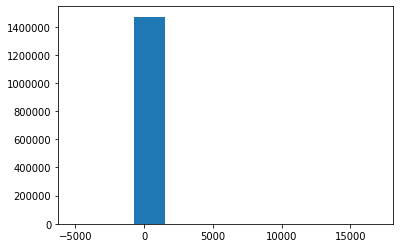

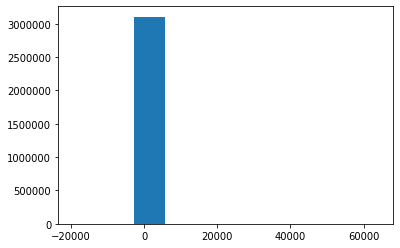

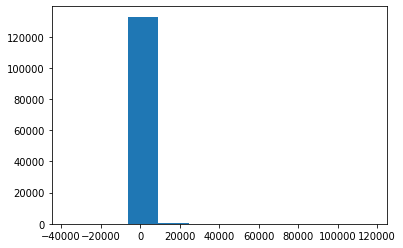

NameError: name 'delta_3' is not defined

<Figure size 432x288 with 0 Axes>

In [16]:
def recover_quake(y_pred, y, means, norms, num_quakes):
    y_pred = y_pred.reshape((num_quakes, -1, 15))
    y = y.reshape((num_quakes, -1, 15))
    
    y = y*np.expand_dims(norms, 1) + np.expand_dims(means, 1)
    y_pred = y_pred*np.expand_dims(norms, 1) + np.expand_dims(means, 1)

    return (y - y_pred).reshape((-1,))

delta_0 = recover_quake(y_pred_0, y_0, val_data_mean0, val_data_var0, len(quakes0))
delta_1 = recover_quake(y_pred_1, y_1, val_data_mean1, val_data_var1, len(quakes1))
delta_2 = recover_quake(y_pred_2, y_2, val_data_mean2, val_data_var2, len(quakes2))
#delta_3 = recover_quake(y_pred_3, y_3, val_data_mean3, val_data_var3, len(quakes3))

plt.figure()
plt.hist(delta_0)
plt.show()

plt.figure()
plt.hist(delta_1)
plt.show()

plt.figure()
plt.hist(delta_2)
plt.show()

plt.figure()
plt.hist(delta_3)
plt.show()

In [17]:
delta_0.shape

(1471140,)

In [18]:
def mae(delta):
    return np.mean(np.abs(delta))
mae(delta_0), mae(delta_1), mae(delta_2)#, mae(delta_3)

(2.4407704933506555, 9.02661874414914, 228.49328712082567)

In [19]:
mae(delta_0)/np.mean(val_data_var0), mae(delta_1)/np.mean(val_data_var1), mae(delta_2)/np.mean(val_data_var2)#, mae(delta_3)/np.mean(val_data_var3)

(0.05351915330113796, 0.044827990852614415, 0.040088650203474546)

In [22]:
from sklearn import metrics

for y_true, y_pred in zip([y_0, y_1, y_2], [y_pred_0, y_pred_1, y_pred_2]):
    print()
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    print("Explained Variance Score:", metrics.explained_variance_score(y_true, y_pred)) 
    print("Max Error Score:", metrics.max_error(y_true, y_pred)) 
    print("Mean Absolute Error Score:", metrics.mean_absolute_error(y_true, y_pred)) 
    print("Mean Squared Error Score:", metrics.mean_squared_error(y_true, y_pred)) 
    print("Median Absolute Error Score:", metrics.median_absolute_error(y_true, y_pred)) 
    print("R2 Score:", metrics.r2_score(y_true, y_pred)) 


Explained Variance Score: 0.36360684369785434
Max Error Score: 1.0345686692603229
Mean Absolute Error Score: 0.06686801007707084
Mean Squared Error Score: 0.01217337479350094
Median Absolute Error Score: 0.03545837218043525
R2 Score: 0.3469841934544178

Explained Variance Score: 0.5216751300379583
Max Error Score: 1.057024127186733
Mean Absolute Error Score: 0.051065925297787924
Mean Squared Error Score: 0.00935696260909213
Median Absolute Error Score: 0.020898166608767282
R2 Score: 0.5068405943635172

Explained Variance Score: 0.6113449051399055
Max Error Score: 1.0416661935702347
Mean Absolute Error Score: 0.04227206870021481
Mean Squared Error Score: 0.007402679132428066
Median Absolute Error Score: 0.016080832568010316
R2 Score: 0.5973651526629721


In [21]:
overall_mae = x_0.shape[0]*mae(delta_0)/np.mean(val_data_var0) + x_1.shape[0] * mae(delta_1)/np.mean(val_data_var1) + x_2.shape[0]*mae(delta_2)/np.mean(val_data_var2)

overall_mae /= x_0.shape[0] + x_1.shape[0] + x_2.shape[0]
overall_mae

0.04740860384121205

In [24]:
r2 = 0
for num, y_true, y_pred in zip([x_0.shape[0], x_1.shape[0], x_2.shape[0]], [y_0, y_1, y_2], [y_pred_0, y_pred_1, y_pred_2]):
    r2 += num*metrics.r2_score(y_true, y_pred)
    
print("Total R2: ", r2 / sum([x_0.shape[0], x_1.shape[0], x_2.shape[0]]))

Total R2:  0.45173256379232474
